# Finding the Happiness Factor
For our CMSC320 class our team did exploratory analysis on the World Happiness Report for 2021 and the World Development Indicators to determine what development factors best correspond with increased happiness across the globe
- Project by Victor Novichkov, Jacob Livchitz

### Downloading the datasets
- Need to have Python installed
- Recommended to install the kaggle pip library
    - ```pip install kaggle```
- Copy the commands listed under the datasets

### Datasets Used
[World Development Indicators - World Bank](https://datacatalog.worldbank.org/dataset/world-development-indicators) (~200MB at time of writing)
- How to download
    - Go to the **Data & Resources** tab
    - Download the **CSV**

[World Happiness Report 2021 - Ajaypal Singh](https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021) (155KB at time of writing)
- How to download
    - ```kaggle datasets download -d ajaypalsinghlo/world-happiness-report-2021```


## Looking at the Happiest Countries

In [17]:
import pandas as pd
import numpy as np

whr_path = './world-happiness-index/whr.csv'
wdi_path = './world-development-index/WDIData_trimmed_n.csv'

whr_data = pd.read_csv(whr_path)
simplified_whr_data = whr_data[['Country name', 'Life Ladder', 'year']] # get just the name / score / and year

countries = pd.unique(simplified_whr_data['Country name'])
print("Total Countries with Indices: {}".format(len(countries)))
print(countries)
wdi_data = pd.read_csv(wdi_path, index_col=0)



Total Countries with Indices: 166
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo (Brazzaville)' 'Congo (Kinshasa)'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark'
 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia'
 'Ethiopia' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong S.A.R. of China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Ivory Coast' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kenya' 'Kosovo' 'Kuwait' 'Kyrgyzstan' 'Laos'
 'Latvia' 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Lithuania' 'Luxembo

In [18]:
print(simplified_whr_data[simplified_whr_data['Country name'] == 'Rwanda']['year'])

1455    2006
1456    2008
1457    2009
1458    2011
1459    2012
1460    2013
1461    2014
1462    2015
1463    2016
1464    2017
1465    2018
1466    2019
Name: year, dtype: int64


## Dealing with Too Much Data
Although the World Bank dataset is amazing, its size is a bit too much for Github to even accept. In order to be able to collaborate we had to cut how much data we were working with. Luckily, there were a couple methods we could use to cut our dataset in half without drastically influencing our analysis
- Get rid of countries in the World Development Index data that don't have corresponding happiness indices
- Get rid of majority NaN/Null datapoints (we won't be looking at them in our analysis)
> Note: The World Happiness Index started in 2012, which means most of the data in the World Development Index going back to 1960 isn't entirely relevant. As a result we can look for rows that have at least 20 non null entries (1990-2020).

```python
# Creating the truncated dataset
wdi_data = pd.read_csv(wdi_path, index_col=0)
wdi_data.head()

# First by removing countries that don't have indices
boolean_mask = wdi_data['Country Name'].isin(countries)
wdi_filtered_data = wdi_data[boolean_mask]
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_filtered_data)/len(wdi_data)))*100))

# Remove all data from 1960 - 1990 (Most of the data from before the the Happiness Index even existed)
wdi_time_adjusted = wdi_filtered_data.drop(axis=1, labels=wdi_cleaned.columns[4:34])
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_time_adjusted.columns)/len(wdi_filtered_data.columns)))*100))

# Get rid of all rows that have less than 5 datapoints over the time period from (1990-2020)
wdi_cleaned = wdi_time_adjusted.dropna(axis=0, thresh=5)
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_cleaned)/len(wdi_time_adjusted))) * 100))

# wdi_cleaned.to_csv('./world-development-index/WDIData_trimmed_n.csv')
```

Since the original dataset could not be uploaded. We can't show the comparison live

But we were able to trim 44.7% of the data just by removing countries without Happiness Indices

And trim a further 45.45% of the data by removing the datapoints from (1960 - 1989), leaving only 1990-2020

And trim an additional 15.99% of the data, dropping our final file size to ~ 27 MB

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '2020', 'Unnamed: 65'],
      dtype='object')
Index(['Country', 'year', 'IPC'], dtype='object')
Index(['Country name', 'Life Ladder', 'year'], dtype='object')


<AxesSubplot:title={'center':'happiness vs time'}, xlabel='year', ylabel='Happy Score'>

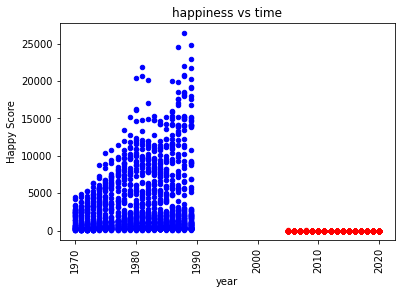

In [19]:
#When one thinks of happiness they think of money. Lets first graph the WHR dataset's graph of national income per capita vs happiness
incomePerCap=pd.DataFrame(columns=['Country','year','IPC'])
yearsValid=wdi_data.columns
print(yearsValid)
yearsValid=yearsValid[4:len(yearsValid)-1]
#print(incomePerCap)
for x, rowX in wdi_data.iterrows():
    if rowX['Indicator Name']=='Adjusted net national income per capita (current US$)':
        for year in yearsValid:
            name=str(rowX['Country Name'])
            yearFinal=int(year)
            if wdi_data.loc[x,year] == np.NaN:
                ipcFinal=np.NaN
            else:
                ipcFinal=float(wdi_data.loc[x,year])
            incomePerCap=incomePerCap.append({'Country':name,'year':yearFinal,'IPC':ipcFinal},ignore_index=True)
#print(simplified_whr_data)
incomePerCap=incomePerCap.dropna()
print((incomePerCap.columns))
print((simplified_whr_data.columns))

#Whats bellow WORKS. its just that the condition year==year will never be matched because the data does not overlap at all!
'''
whrIPC=pd.DataFrame(columns=['Country','year','Score','IPC'])
print(len(whrIPC))

for x, rowX in incomePerCap.iterrows():
    for y,rowY in simplified_whr_data.iterrows():
        if rowX['Country']==rowY['Country name'] and rowX['year']==rowY['year']:
            name=str(rowX['Country'])
            yearFinal=int(rowX['year'])
            ipcFinal=float(rowX['IPC'])
            score=float(rowY['Life Ladder'])
            whrIPC = whrIPC.append({'Country':name,'year':yearFinal,'Score':score,'IPC':ipcFinal},ignore_index=True)
print(whrIPC.head(100))'''

ax=incomePerCap.plot.scatter(x='year',xlabel='year',y='IPC',ylabel='income per capita',rot=90,color='b',title='year vs income per cap.')
simplified_whr_data.plot.scatter(x='year',xlabel='year',y='Life Ladder',ylabel='Happy Score',rot=90,color='r',title='happiness vs time',ax=ax)
